In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import matplotlib.pyplot as plt
import cv2
import rasterio
import numpy as np
from satellitepy.data.labels import read_label
from satellitepy.data.tools import show_labels_on_images
from satellitepy.data.utils import read_img
from pathlib import Path
from satellitepy.data.patch import get_patches

# PIL.Image.MAX_IMAGE_PIXELS = 715538754

# Read an fr24 image and its label file

In [3]:
img_path = '/mnt/2tb-1/satellitepy/data/FR24_dataset/images/Amsterdam_23MAR14104929.tif'
# img_path = '/home/murat/Projects/satellitepy/data/DOTA/datasplit/images/P0001__1__228___1848.png'
# label_path = '/mnt/2tb-1/satellitepy/data/FR24_dataset/labels_fineair/role_th_50/Harry_Reid_International_Airport_23NOV25183153.geojson'

In [4]:
print(Path(img_path).is_file())

True


# READ IMAGE

## Rasterio

In [5]:
# img = cv2.imread(img_path)
with rasterio.open(img_path) as src:
    # Read the image as a numpy array
    img_array = src.read()

    # Get image metadata
    metadata = src.meta
    print(img_array.shape)

    img = np.transpose(img_array, axes=(1, 2, 0))  # Shape: (H, W, C)
    print(img.shape)


(4, 30114, 23761)
(30114, 23761, 4)


In [3]:
def resize_img(img, resize_factor=0.2):
    height, width = img.shape[:2]

    # Calculate the new dimensions
    new_width = int(width * resize_factor)
    new_height = int(height * resize_factor)

    # Resize the image
    img_resized = cv2.resize(img, (new_width, new_height))
    print(img_resized.shape)
    return img_resized
def show_side_by_side(img):
    rgb = img[..., :3]
    nir = img[..., 3]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(rgb)
    axes[0].set_title("RGB")
    axes[0].axis('off')

    axes[1].imshow(nir, cmap='gray')
    axes[1].set_title("NIR")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
def plot_channel_histograms(img, channel_names=None):
    """
    Plots the histogram of each channel in the image side by side.

    Parameters:
    - img: Input image, assumed to be in (H, W, C) format.
    - channel_names: List of channel names (optional). Defaults to ["Channel 1", "Channel 2", ...].
    """
    num_channels = img.shape[2] if len(img.shape) == 3 else 1
    channel_names = channel_names or [f"Channel {i + 1}" for i in range(num_channels)]
    
    # Create subplots
    fig, axes = plt.subplots(1, num_channels, figsize=(15, 5))
    if num_channels == 1:  # If grayscale, ensure axes is iterable
        axes = [axes]

    for i in range(num_channels):
        channel = img[..., i].ravel()  # Flatten the channel
        axes[i].hist(channel, bins=256, range=(1, np.max(img)), color='gray', alpha=0.7)
        axes[i].set_title(channel_names[i])
        axes[i].set_xlim(1, np.max(img))
        axes[i].set_xlabel("Pixel Value")
        axes[i].set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()
def print_channel_amax(img, channel_names=None):
    """
    Prints the maximum pixel value (amax) for each channel in the image.

    Parameters:
    - img: Input image, assumed to be in (H, W, C) format.
    - channel_names: List of channel names (optional). Defaults to ["Channel 1", "Channel 2", ...].
    """
    num_channels = img.shape[2] if len(img.shape) == 3 else 1
    channel_names = channel_names or [f"Channel {i + 1}" for i in range(num_channels)]
    
    print("Maximum values (amax) for each channel:")
    for i in range(num_channels):
        max_value = np.amax(img[..., i])
        print(f"{channel_names[i]}: {max_value}")
def convert_16bit_to_8bit_global(img_16bit):
    """
    Converts a 16-bit multi-channel image to 8-bit while preserving channel correlations.
    
    Parameters:
    - img_16bit: Input 16-bit image as a numpy array (H, W, C).
    
    Returns:
    - img_8bit: Converted 8-bit image as a numpy array.
    """
    # Determine global range (across all channels)
    img_min = np.min(img_16bit)
    img_max = np.max(img_16bit)
    print(f"16-bit Image Global Range: min={img_min}, max={img_max}")
    
    # Normalize globally to 0–255
    img_normalized = (img_16bit - img_min) / (img_max - img_min) * 255.0
    img_8bit = np.clip(img_normalized, 0, 255).astype(np.uint8)
    
    return img_8bit

def convert_16bit_to_8bit_percentile(img, lo_percent=1, hi_percent=99):
    lo = np.percentile(img, lo_percent)
    hi = np.percentile(img, hi_percent)
    img_clipped = np.clip(img, lo, hi)
    img_normalized = (img_clipped - lo) / (hi - lo) * 255.0
    return np.clip(img_normalized, 0, 255).astype(np.uint8)


In [9]:
np.max(img)

2047

# Normalization steps

## CLAHE

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_clahe = np.zeros_like(img, dtype=np.uint8)
for i in range(img.shape[2]):
    img_clahe[..., i] = clahe.apply(img[..., i].astype(np.uint8))

print(np.amax(img_clahe[...,:]))
print(img_clahe.shape)
img_clahe_resized = resize_img(img_clahe)
show_side_by_side(img_clahe_resized)


## Percentile approach

In [ ]:
# Normalize each channel individually using percentile stretch
img_normalized = np.zeros_like(img, dtype=np.float32)
for i in range(img.shape[2]):  # Iterate over channels
    channel = img[..., i]
    lo, hi = np.percentile(channel, (1, 99))  # Stretch between 1st and 99th percentile
    img_normalized[..., i] = (channel.astype(float) - lo) * (255 / (hi - lo))

# Clip and convert to uint8
img_normalized = np.clip(img_normalized, 0, 255).astype(np.uint8)


(12045, 9504, 4)


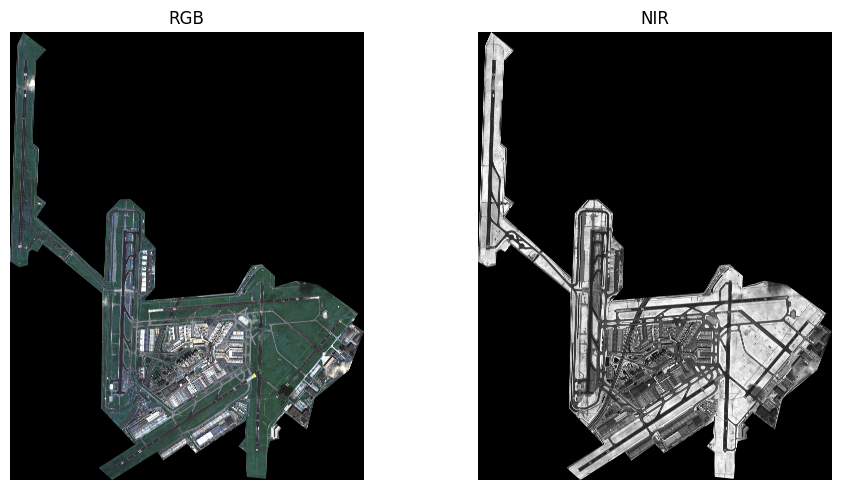

True

In [18]:
img_percentile_resized = resize_img(img_normalized, resize_factor=0.4)
show_side_by_side(img_percentile_resized)
save_resized_path = '/home/murat/Projects/satellitepy/docs/temp_fineair_set/images/Amsterdam_23MAR14104929.png'
cv2.imwrite(save_resized_path,img_percentile_resized)

### Test saved image

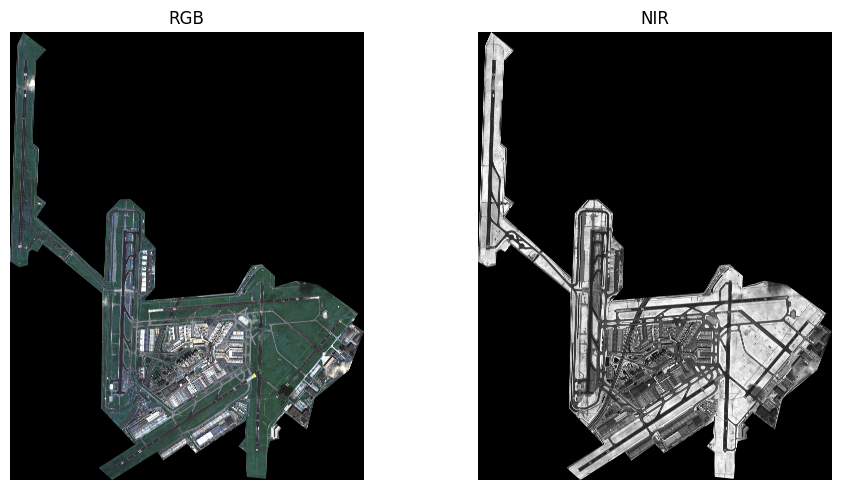

In [20]:
img_to_test = cv2.imread(save_resized_path, cv2.IMREAD_UNCHANGED)
show_side_by_side(img_to_test)


16-bit Image Global Range: min=0, max=2047


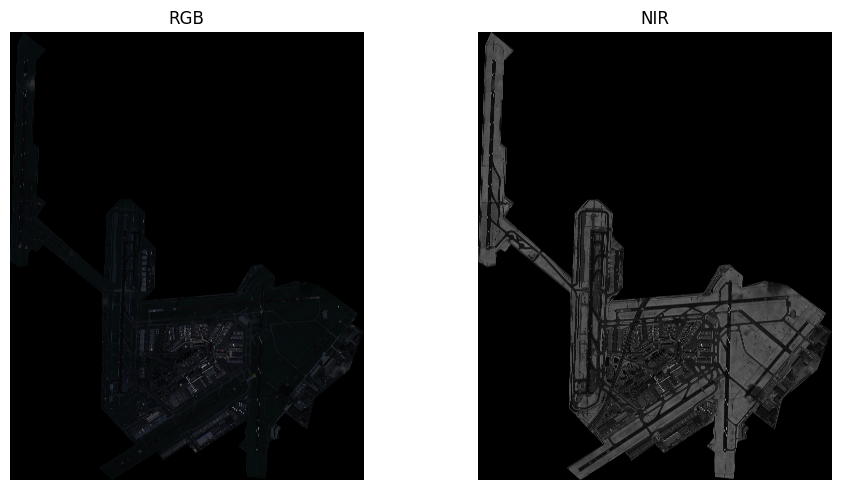

In [ ]:
img_8bit = convert_16bit_to_8bit_global(img)
show_side_by_side(img_8bit)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


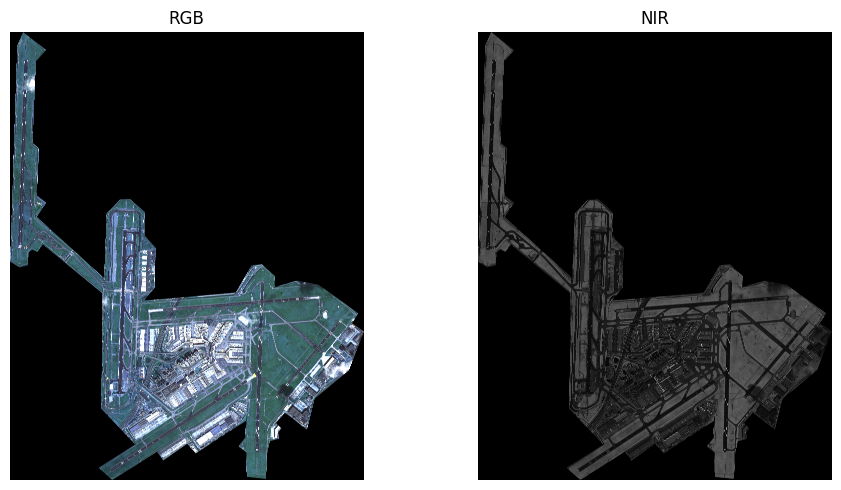

In [12]:
show_side_by_side(img)

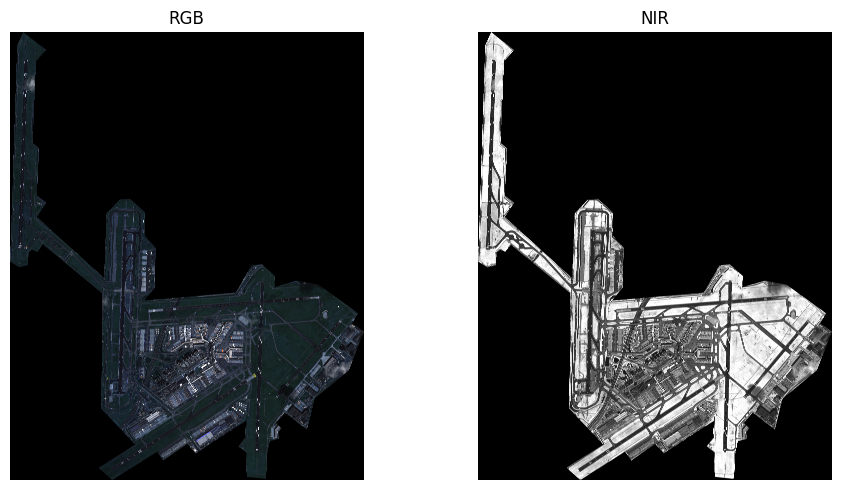

In [16]:
img_8bit = convert_16bit_to_8bit_percentile(img)
show_side_by_side(img_8bit)

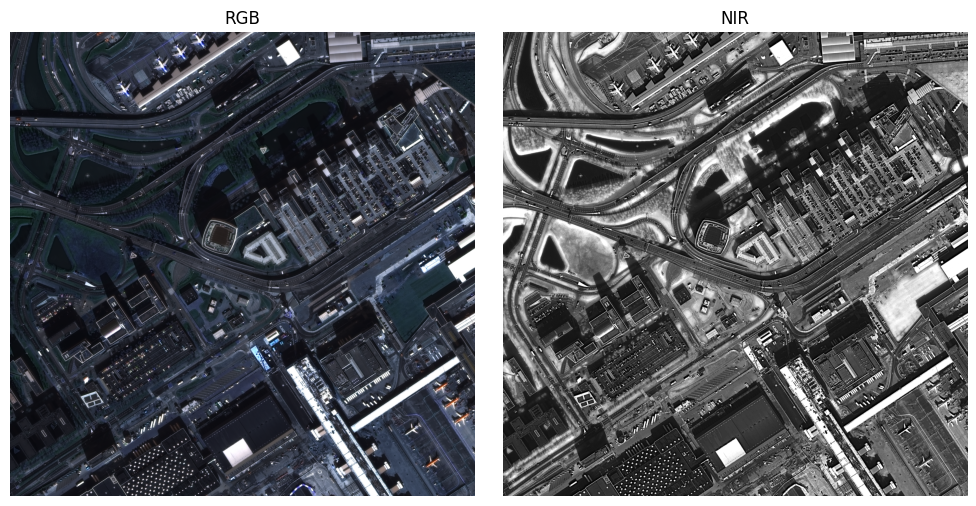

In [25]:
show_side_by_side(img_8bit[21000:24000,10000:13000,:])

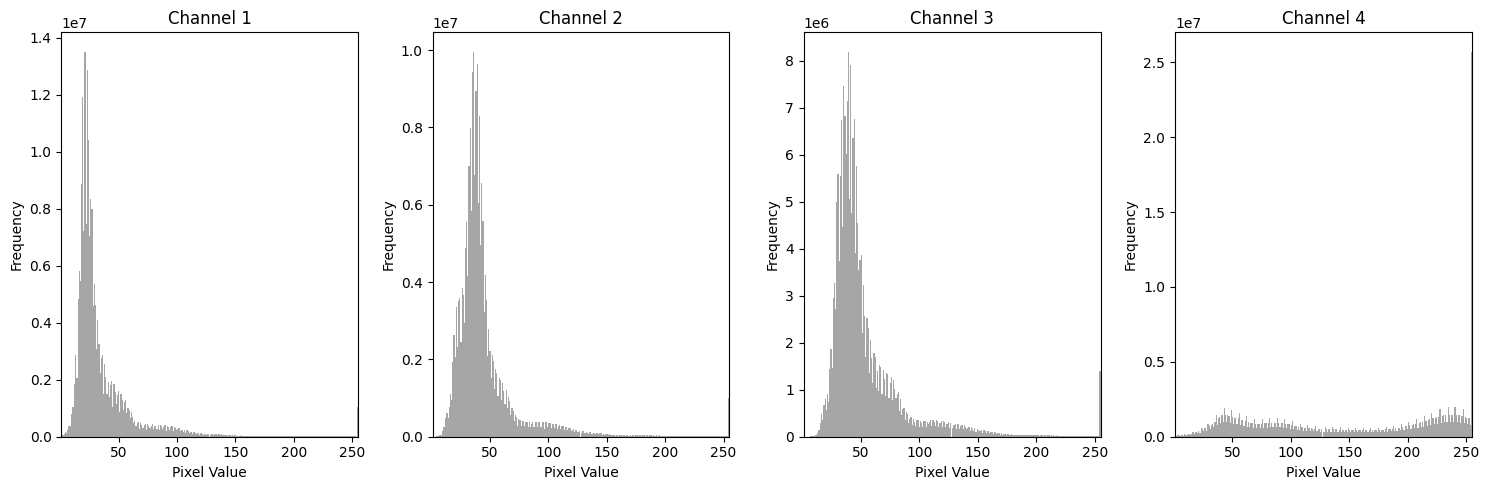

In [22]:
plot_channel_histograms(img_8bit)

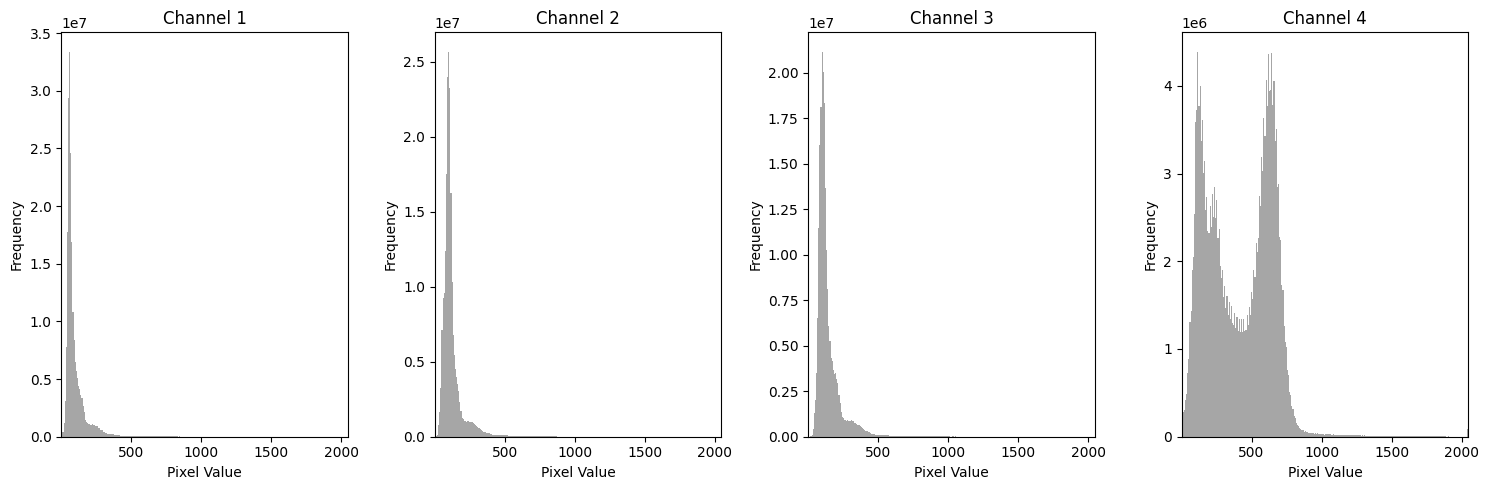

In [23]:
plot_channel_histograms(img)

In [14]:
print_channel_amax(img_8bit)

Maximum values (amax) for each channel:
Channel 1: 255
Channel 2: 216
Channel 3: 237
Channel 4: 255


# Temporary json files

In [ ]:
import os
import json

# Function to load a JSON file
def load_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# Function to save a JSON file
def save_json(data, file_path):
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=4)

# Function to update JSON data
def update_json(data):
    if 'gt_labels' in data:
        data['gt_labels']['fineair-class'] = data['gt_labels'].pop('fine-class')
    return data

# Function to process JSON files in a folder
def process_json_files(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for filename in os.listdir(input_folder):
        if filename.endswith('.json'):
            file_path = os.path.join(input_folder, filename)
            
            # Load the JSON file
            data = load_json(file_path)
            
            # Update the JSON data
            updated_data = update_json(data)
            
            # Save the updated JSON file to the output folder
            output_file_path = os.path.join(output_folder, filename)
            save_json(updated_data, output_file_path)
            print(f"Processed file: {filename}")

# Define input and output folders
input_folder = '/home/murat/Projects/satellitepy/exps/roi_trans_fineair/results/patch_labels'
output_folder = '/home/murat/Projects/satellitepy/exps/roi_trans_fineair/results/patch_labels_with_fineair'

# Process the JSON files
process_json_files(input_folder, output_folder)


# Remove non overlapping patch file labels

In [ ]:
import os

# Function to get a set of filenames in a folder
def get_filenames(folder):
    return set(os.listdir(folder))

# Function to remove non-overlapping files
def remove_non_overlapping_files(folder1, folder2):
    # Get the sets of filenames in each folder
    filenames1 = get_filenames(folder1)
    filenames2 = get_filenames(folder2)
    
    # Find the overlapping filenames
    overlapping_filenames = filenames1 & filenames2
    
    # Remove non-overlapping files from folder1
    for filename in filenames1 - overlapping_filenames:
        file_path = os.path.join(folder1, filename)
        os.remove(file_path)
        print(f"Removed {file_path}")
    
    # Remove non-overlapping files from folder2
    for filename in filenames2 - overlapping_filenames:
        file_path = os.path.join(folder2, filename)
        os.remove(file_path)
        print(f"Removed {file_path}")

# Define the folders to compare
folder1 = '/mnt/2tb-1/satellitepy/data/FR24_patches/test/labels/'
folder2 = '/home/murat/Projects/satellitepy/exps/roi_trans_fineair/results/patch_labels'

# Remove non-overlapping files
remove_non_overlapping_files(folder1, folder2)


# Convert fineair classes in dota label files into CGC

In [4]:
from satellitepy.utils.path_utils import get_file_paths, create_folder
from pathlib import Path
from satellitepy.data.labels import read_label

set_name = 'train'
class_name = 'fac'

class_dict = {'cgc':'coarse-class', 'fac':'fineair-class'}
class_full_name = class_dict[class_name]

label_folder = Path(f'/mnt/2tb-1/satellitepy/data/FR24_patches/ps_1024_balanced_sets/{set_name}_alpha/labels/')
label_paths = get_file_paths(label_folder)

out_label_folder = Path(f'/mnt/2tb-1/satellitepy/data/FR24_patches/ps_1024_balanced_sets/{set_name}_alpha/labels_dota_{class_name}/')

create_folder(out_label_folder)

for label_path in label_paths:
    out_label_path = out_label_folder / f"{label_path.stem}.txt"
    f_out = open(out_label_path,'w+')
    label = read_label(label_path=label_path,label_format='satellitepy')
    obboxes = label['obboxes']
    for i, obbox in enumerate(obboxes):
        fineair_class = label[class_full_name][i]
        fineair_class = fineair_class.replace(' ', '-')
        obbox_1d = [str(corner) for obbox_corners in obbox for corner in obbox_corners]
        cgc_bbox_line = ' '.join(obbox_1d) + ' ' + str(fineair_class) + ' ' + '0' + '\n'
        f_out.write(cgc_bbox_line)

    f_out.close()
    


# Check the RGB from RGBNIR images

In [6]:
img_path_orig_rgb = '/mnt/2tb-1/satellitepy/data/FR24_sets/train/images/Amsterdam_23MAR14104929.png'
img_path_rgbn = '/mnt/2tb-1/satellitepy/data/FR24_sets/train/images_alpha/Amsterdam_23MAR14104929.png'

In [7]:
img_orig_rgb = cv2.imread(img_path_orig_rgb,cv2.IMREAD_UNCHANGED)
img_rgbn = cv2.imread(img_path_rgbn,cv2.IMREAD_UNCHANGED)



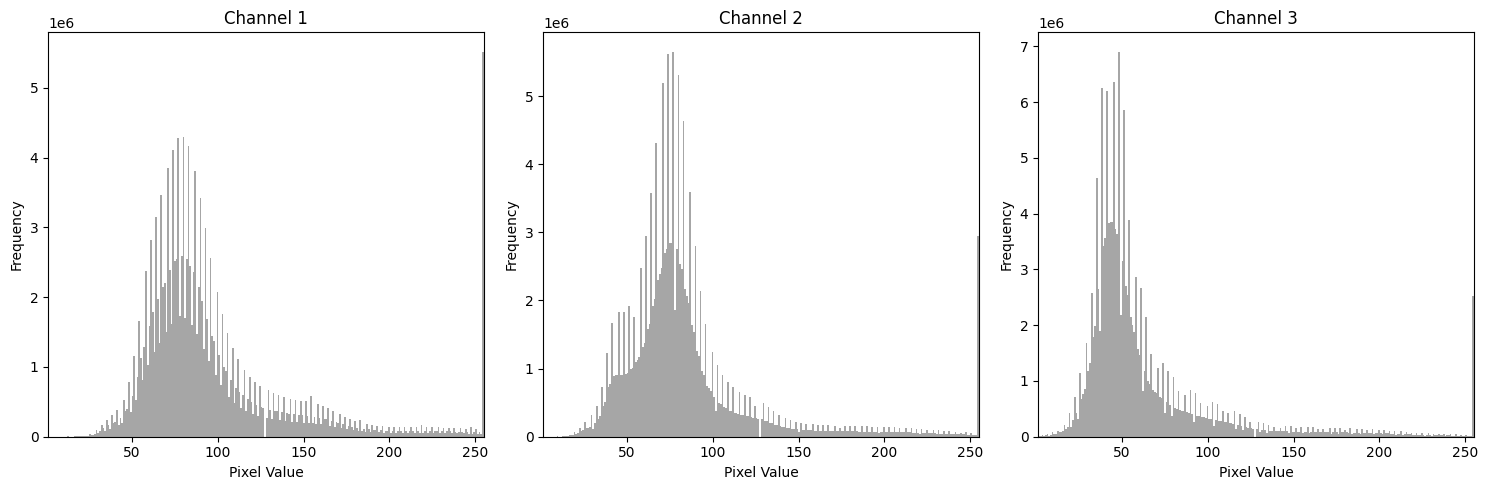

In [8]:
plot_channel_histograms(img_orig_rgb)

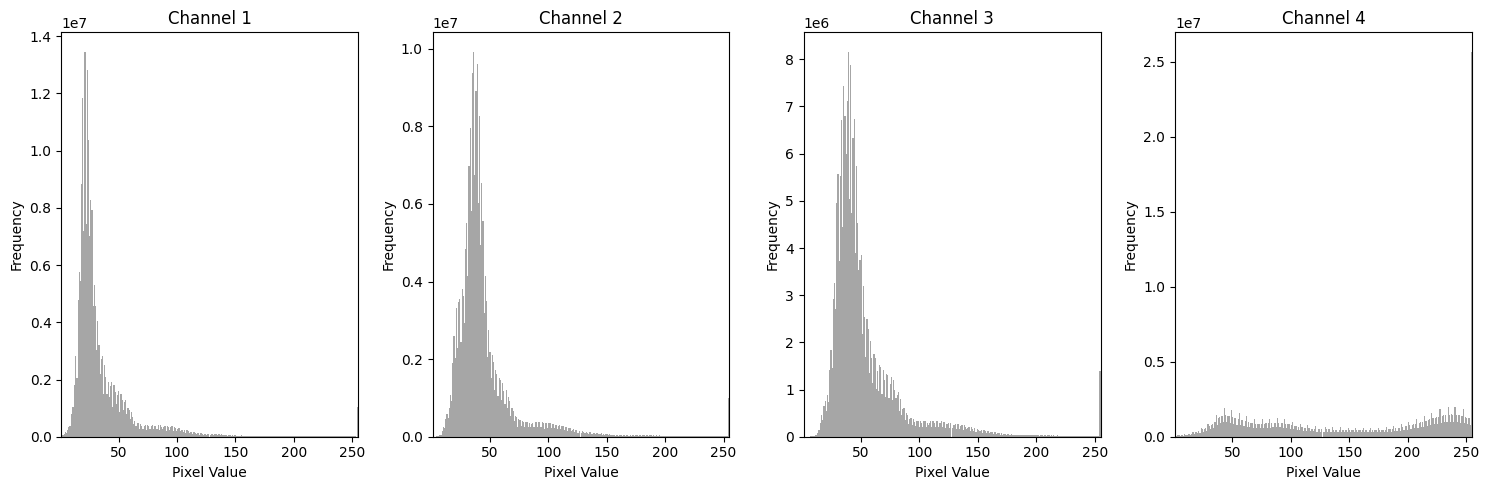

In [9]:
plot_channel_histograms(img_rgbn)

# Save 3 channels from 4 channel images

In [2]:
import os
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = str(pow(2,40))
import cv2

# Define the folder paths
# input_folder = "/mnt/2tb-1/satellitepy/data/FR24_sets/test/images_alpha/"  # Replace with your 4-channel image folder path
# output_base_folder = "/mnt/2tb-1/satellitepy/data/FR24_sets/test/images_alpha_3ch/"  # Replace with desired output folder path

input_folder = "/mnt/2tb-1/satellitepy/data/FR24_patches/ps_1024_balanced_sets/train_alpha/images"
output_base_folder = "/mnt/2tb-1/satellitepy/data/FR24_patches/ps_1024_balanced_sets/train_alpha/images_alpha_3ch/"  # Replace with desired output folder path

# Define the channel combinations
channel_combinations = {
    "B-G-NIR": [0, 1, 3],  # Blue, Green, NIR
    "B-G-R": [0, 1, 2],    # Blue, Green, Red
    "NIR-G-R": [3, 1, 2],  # NIR, Green, Red
    "B-NIR-R": [0, 3, 2],  # Blue, NIR, Red
}

# Create a folder for each combination
for combo_name in channel_combinations.keys():
    os.makedirs(os.path.join(output_base_folder, combo_name), exist_ok=True)

# Process each image in the input folder
for img_name in os.listdir(input_folder):
    if img_name.lower().endswith((".png", ".tiff", ".tif")):  # Filter valid image files
        print(f'Processing {img_name}...')
        # Read the 4-channel image
        img_path = os.path.join(input_folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)  # Read as 4-channel

        if img is None or img.shape[2] != 4:
            print(f"Skipping {img_name}: Not a 4-channel image.")
            continue

        # Generate and save each combination
        for combo_name, channels in channel_combinations.items():
            # Extract the selected channels
            combo_img = img[..., channels]

            # Save the combination image in the respective folder
            output_path = os.path.join(output_base_folder, combo_name, img_name)
            cv2.imwrite(output_path, combo_img)

print("Processing complete. Each combination has its own folder.")

Processing Cairo_24JAN29084910_x_16632_y_4620.png...
Processing O_Hare_Int_Airport_22OCT23164249_x_8316_y_11088.png...
Processing Beijing_Capital_International_22DEC04031345_x_11088_y_12012.png...
Processing Guangzhou_Baiyun_International_Airport_22OCT10032231_x_4620_y_10164.png...
Processing Dallas_Fort_Worth_23FEB22171239_x_20328_y_1848.png...
Processing Frankfurt_22MAR22103647_x_22176_y_3696.png...
Processing King_Fahd_23JUL18072645_x_5544_y_15708.png...
Processing Orlando_International_Airport_24FEB16160844_x_7392_y_6468.png...
Processing Beijing_Capital_International_22DEC04031345_x_1848_y_9240.png...
Processing Shanghai_23APR13022829_x_4620_y_6468.png...
Processing Toronto_23MAY27162713_x_10164_y_3696.png...
Processing Madrid_23MAR28111507_x_5544_y_29568.png...
Processing Harry_Reid_International_Airport_23NOV25183153_x_1848_y_4620.png...
Processing Denver_International_Airport_23JUN19175130_x_14784_y_20328.png...
Processing Orlando_International_Airport_24FEB16160844_x_12012_y_9